In [1]:
import os
os.chdir("/shareN/data8/SwapTmp/fy/Spatial/ARGA-ARVGA/Data/Visium/raw/T-GRAASP/")
import torch
from models import STx_ARGVA, STx_encoder, STx_discriminator
from utils import *
from train import Trainer
import matplotlib
import pandas as pd
matplotlib.rcParams['pdf.fonttype'] = 42 

import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings("ignore", category=ConstantInputWarning)

# sample_ids = ['CAQSC','WYYBT','XXGBT','ZWFBT','ZWJBT']
sample_ids = ['Young1','Mid1','Old1','Young2', 'Mid2',  'Old2']
# sample_ids = ['Young1']
raw_dir = '/shareN/data8/SwapTmp/fy/Spatial/ARGA-ARVGA/Data/Visium/raw'
test_ratio = 0.1


sp_graph_list, sp_adj_list = SGEDataset(sample_ids, raw_dir, test_ratio=0.10)
# sc_graph_list = SGEDataset1(sample_ids, raw_dir)

N_nodes   = sp_graph_list[0].x.size(0)   # 节点个数
F_inputs  = sp_graph_list[0].x.size(1)   

ppi_file     = f'{raw_dir}/PPI1.connect.txt'
ppi = pd.read_csv(ppi_file,sep = " ", index_col=None ,header = None)
connectivity = load_ppi_connectivity(ppi_file, F_inputs)    # shape = [2, E]

Loading sample Young1 
Loading sample Mid1 
Loading sample Old1 
Loading sample Young2 
Loading sample Mid2 
Loading sample Old2 


In [2]:
encoder = STx_encoder(
    in_channels      = F_inputs,        
    hidden_channels  = 96,
    out_channels     = 16,
    m = 29, l = 3, K = 3,
    connect = connectivity,        
    pi = 0.75,
    n_heads = 8,
    activate_sc_alignment=False
)

discriminator = STx_discriminator(
    in_channels     = 16,  
    hidden_channels = 8,   
    out_channels    = 1
)

model = STx_ARGVA(
    encoder      = encoder,
    discriminator= discriminator,
    l            = 3          
)

In [4]:
model.load_state_dict(torch.load('raw_dir','result/best_model_knn_noy_Young2_0.1.pkl'))
model.eval()
data = sp_graph_list[3]
z, _= model.encode(None, data.x,None,None, None, None)

In [8]:
import numpy as np
import pandas as pd
from scripts.CustomFunc import onehot_to_label, sqrtm

s = data.x.size(0)
u = model.__u__
adj = model.decoder.forward_all(z)
adj1 = model.__adj1__.squeeze(0)
cl = u.cpu().softmax(dim=-1)
cluster = onehot_to_label(cl.t()).values.reshape(-1)
adj = pd.DataFrame(adj.detach().cpu())
# adj1 = pandas.DataFrame(adj1.detach().cpu())
z1 = pd.DataFrame(z.detach().cpu())
u = pd.DataFrame(u.detach().cpu())
y = np.array(data.y.detach().cpu())

In [11]:

spatial_data_eval = sp_graph_list[3]
# sc_data_eval = adj_list[7]
adj_spatial = sp_adj_list[3]
z_spatial_eval, _ = model.encode(None, spatial_data_eval.x, None, None, None, None)
m_spatial_eval = model.__m__.clone().detach()
# z_sc_eval, _ = model.encode(None, sc_data_eval.x, None, None, None, None)

z_spatial = model.decoder.forward_all(z_spatial_eval)
# adj_sc = model.decoder.forward_all(z_sc_eval) # Not used if structure loss is removed but kept for consistency

block_spatial = compute_block_matrix(adj_spatial, spatial_data_eval.y, threshold=0.6, is_prediction=True)
block_spatial1 = compute_block_matrix(z_spatial, spatial_data_eval.y, threshold=0.6, is_prediction=True) 
# For block_sc, we'd typically use sc_data_eval.y if available and meaningful for block comparison
# Assuming sc_data_eval.y has cluster labels for scRNA-seq data that can be compared to spatial

# block_sc = compute_block_matrix(adj_sc, sc_data_eval.y, threshold=0.6, is_prediction=True)
# block_corr, _ = compare_block_matrices(block_spatial, block_sc)

compare_block_matrices(block_spatial, block_spatial1)

(0.5601318921009495, 6.570625498677569e-35)

Correlation (upper triangle): 0.5601318921009495
P-value: 6.570625498677569e-35


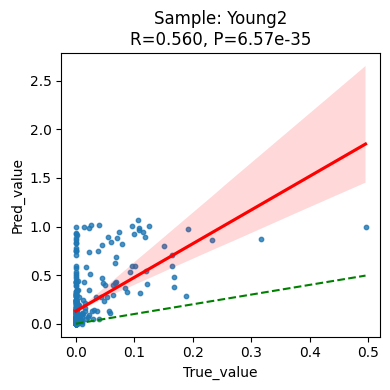

In [16]:
import numpy as np
from scipy.stats import pearsonr

common_columns = sorted(set(block_spatial.columns).intersection(set(block_spatial1.columns)))

# 重新对齐两个矩阵，
result_sc1 = block_spatial1.reindex(index=common_columns, columns=common_columns)
result_sp1 = block_spatial.reindex(index=common_columns, columns=common_columns)
result_sc1 = (result_sc1 + result_sc1.T) / 2
result_sp1 = (result_sp1 + result_sp1.T) / 2


# 取上三角索引（不包含对角线）
triu_indices = np.triu_indices_from(result_sp1, k=1)

# 提取上三角元素
vec1 = result_sp1.values[triu_indices]
vec2 = result_sc1.values[triu_indices]

# 计算Pearson相关系数
correlation, p_value = pearsonr(vec1, vec2)

print("Correlation (upper triangle):", correlation)
print("P-value:", p_value)

sample_names = ['Young1','Mid1','Old1','Young2', 'Mid2',  'Old2']
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
true_all = []
pred_all = []
true_all.extend(vec1)
pred_all.extend(vec2)

# 转为 DataFrame
df = pd.DataFrame({
    "True_value": true_all,
    "Pred_value": pred_all
})

# 计算相关性和P值
corr, p_value = pearsonr(df["True_value"], df["Pred_value"])

# 绘图
plt.figure(figsize=(4, 4))
sns.regplot(
    x="True_value",
    y="Pred_value",
    data=df,
    scatter_kws={"s": 10},
    line_kws={"color": "red"}
)
plt.plot(
    [df["True_value"].min(), df["True_value"].max()],
    [df["True_value"].min(), df["True_value"].max()],
    'g--'#, label="True=Pred"

)
plt.title(f"Sample: {sample_names[3]}\nR={corr:.3f}, P={p_value:.2e}")
# plt.legend()
plt.savefig(f"./result/{sample_names[3]}.pdf", dpi=300)
plt.tight_layout()
# plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import scanpy as sc
adata = sc.AnnData(np.array(z1))
adata.obsm['x'] =  adata.X
truth = pd.read_csv("/Data/Visium_brain/Young2_truth.txt", sep=" ")
count = pd.read_csv("/Data/Visium_brain/Young2_hvg_counts.txt",sep=" ",header=0)

In [19]:

pos = pd.read_csv("/Data/Visium_brain/Young2_position.txt",sep=" ")
pos['imagecol'] = -pos['imagecol']
coordinates = np.array(pos.iloc[:,0:2])
adata.obsm['spatial'] = coordinates

/home/fengyang/.conda/envs/geometric2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_64836/1958912532.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.4)


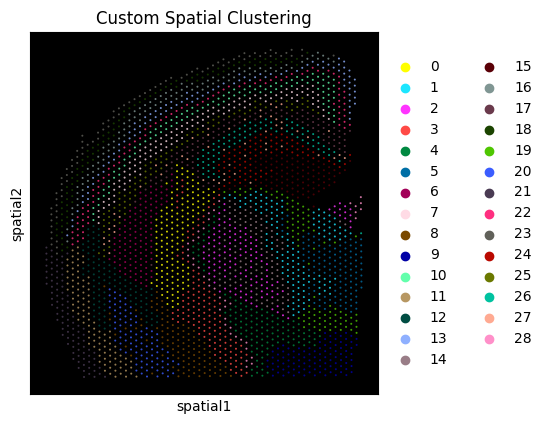

0.34145549123766866
0.77073646
2790.3141553635096


In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
sc.pp.neighbors(adata, use_rep='x',
                n_neighbors = 15)
sc.tl.leiden(adata, resolution=0.4)
with mpl.rc_context({'axes.facecolor':  'black',
                'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(
        adata,
        color=['leiden'],
        size=1,
        spot_size=30,      # 根据坐标范围调整
        img_key=None,      # 无图像叠加
        library_id=None,   # 禁用预设 library_id
        alpha=0.8,
        title="Custom Spatial Clustering"
    )
pos["Leiden_15_0.1"] =np.array(adata.obs['leiden'])
print(metrics.davies_bouldin_score(adata.obsm['x'], adata.obs['leiden']))
print(metrics.silhouette_score(adata.obsm['x'], adata.obs['leiden']))
print(metrics.calinski_harabasz_score(adata.obsm['x'], adata.obs['leiden']))

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import scanpy as sc
import pandas as pd
import numpy as np
adata_vis = sc.AnnData(np.array(count.T))
adata_vis.obsm['x'] =  adata_vis.X
adata_vis.var.index = count.index
adata_vis.obs['truth'] = truth['clusterLevel'].values

/home/fengyang/.conda/envs/geometric2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/fengyang/.conda/envs/geometric2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/fengyang/.conda/envs/geometric2/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:440

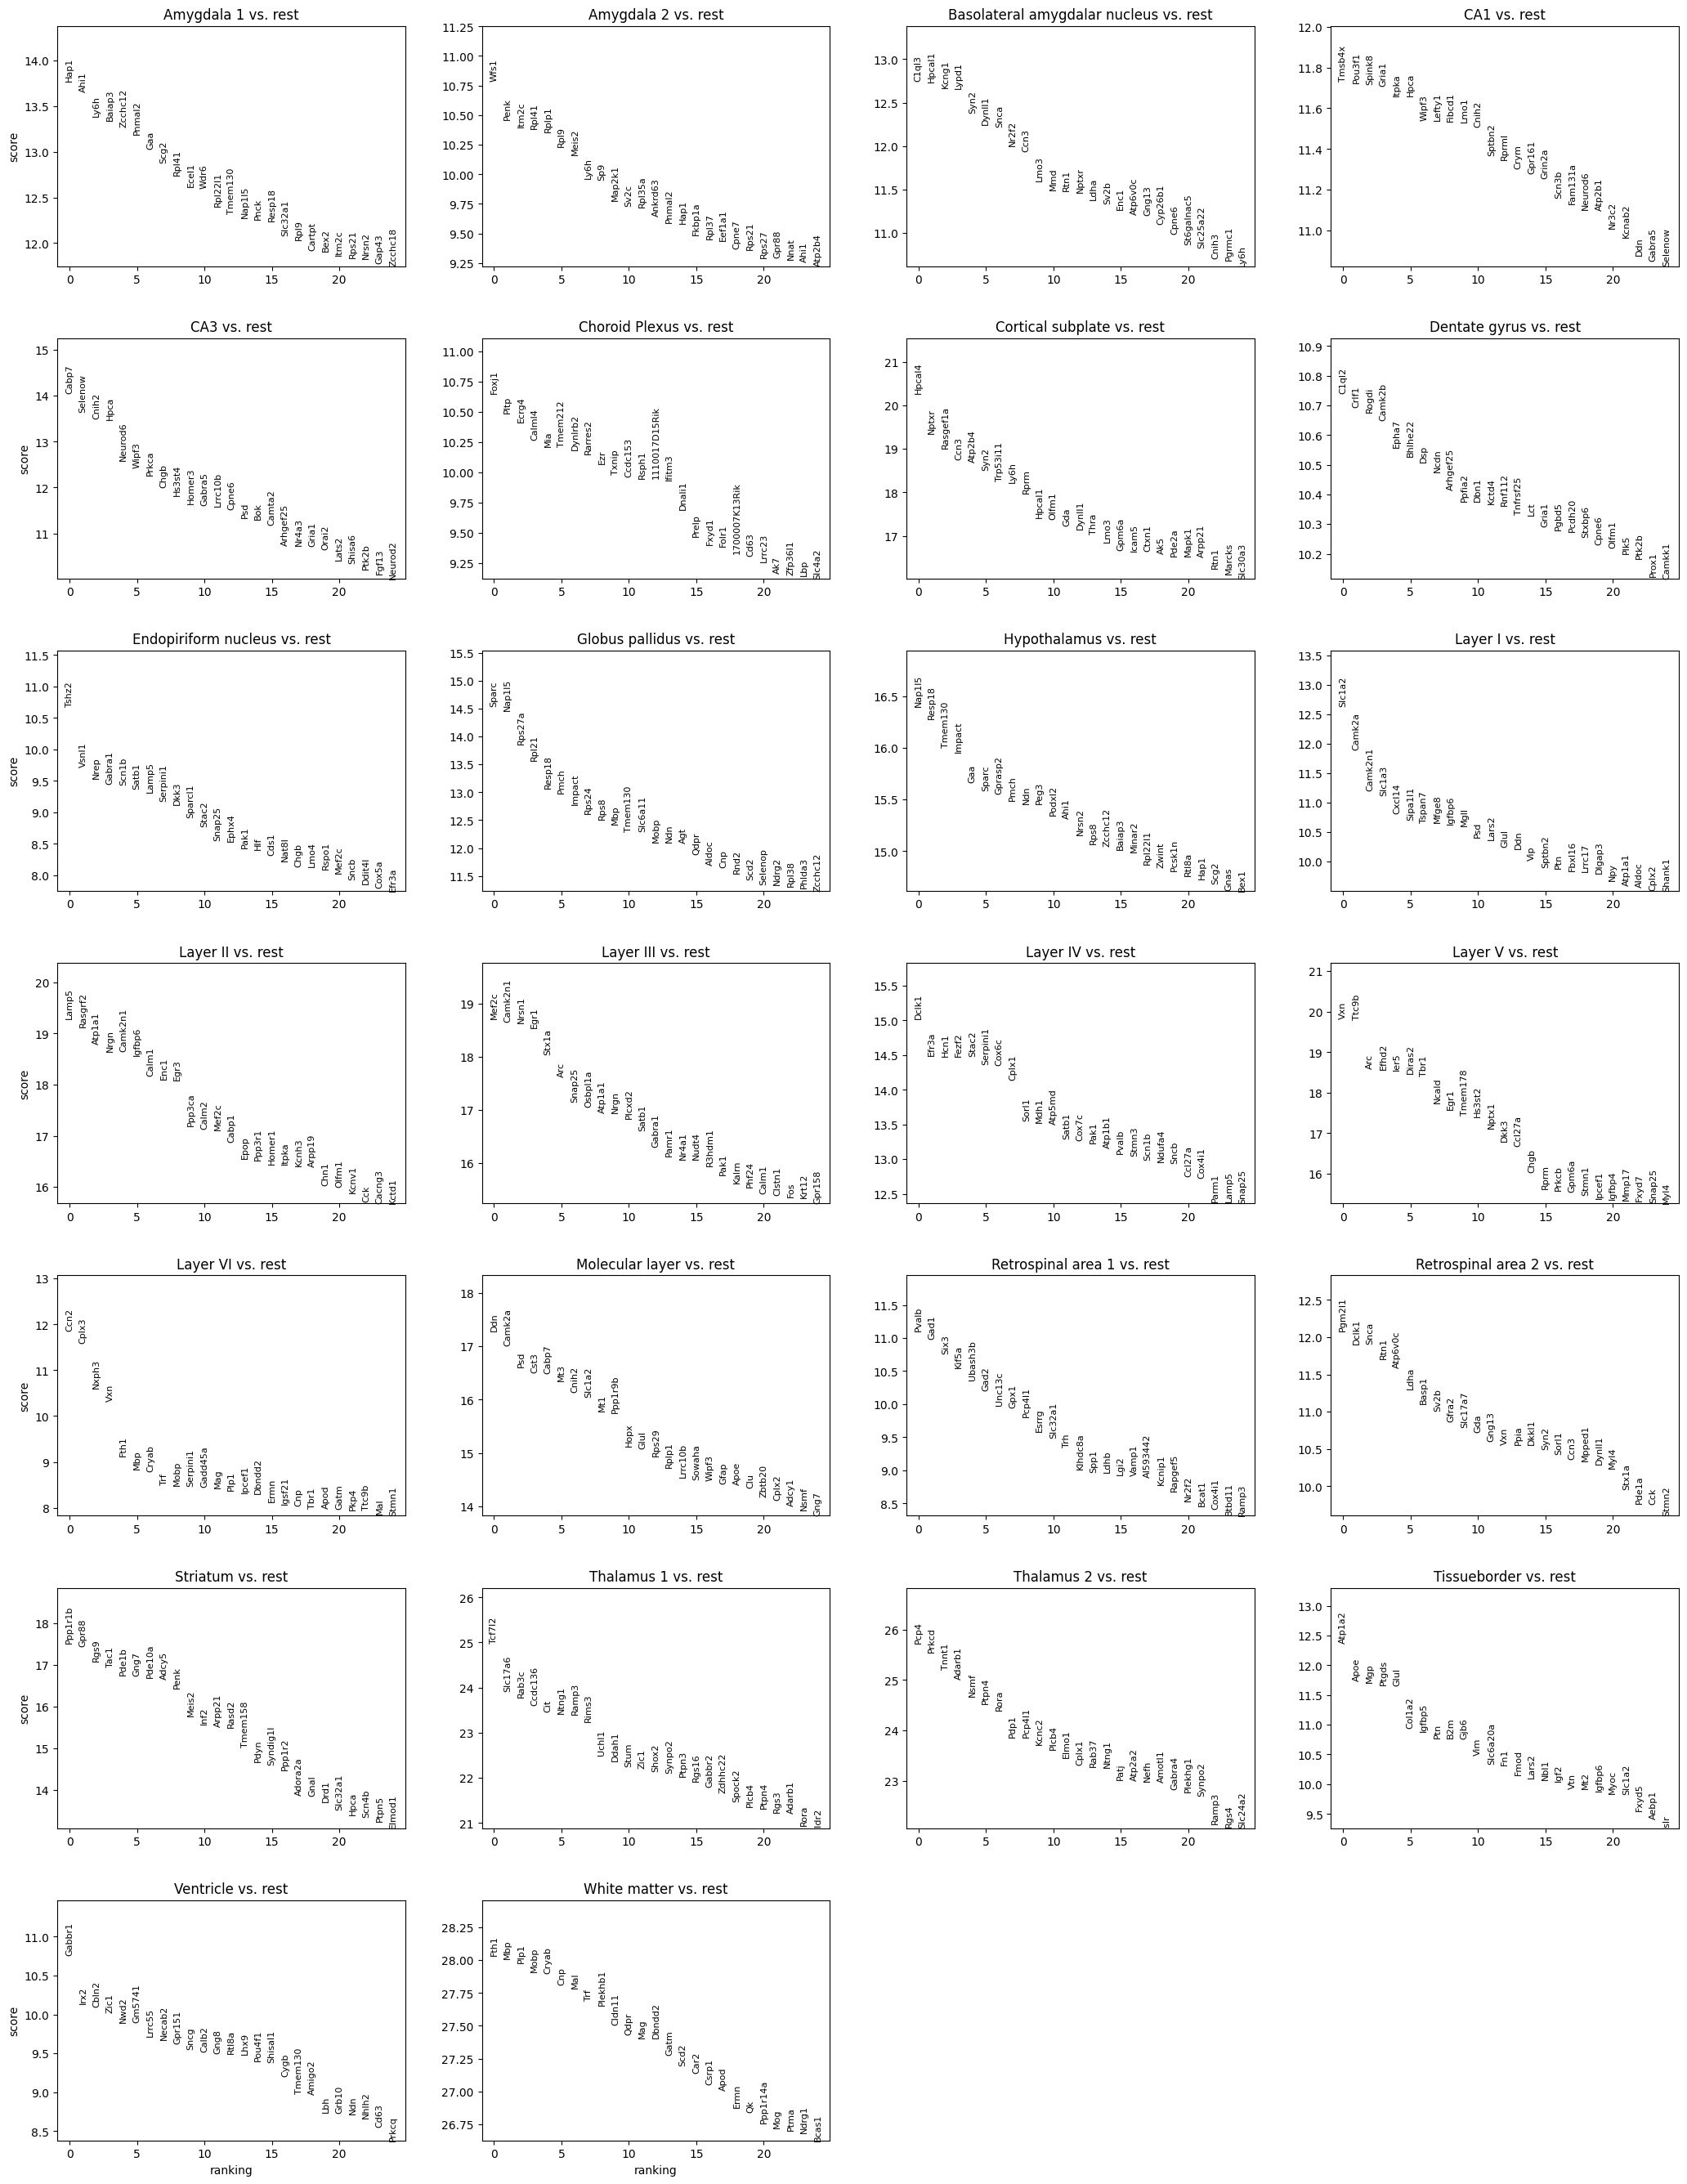

In [23]:
sc.pp.normalize_total(adata_vis, target_sum=1e4) # 不要和log顺序搞反了 ，这个是去文库的
sc.pp.log1p(adata_vis)
sc.tl.pca(adata_vis, svd_solver='arpack')
sc.tl.rank_genes_groups(adata_vis, 'truth', method='wilcoxon')
sc.pl.rank_genes_groups(adata_vis, n_genes=25, sharey=False)

In [24]:
import pandas as pd

# 提取结果
result = adata_vis.uns['rank_genes_groups']
groups = result['names'].dtype.names  # 获取group名（即各个分簇的标签）
n_genes = 25  # 你想导出的marker数量

# 构造DataFrame存储所有簇的marker
all_markers = []

for group in groups:
    for i in range(n_genes):
        gene = result['names'][group][i]
        logfc = result['logfoldchanges'][group][i]
        pval = result['pvals'][group][i]
        pval_adj = result['pvals_adj'][group][i]
        score = result['scores'][group][i] if 'scores' in result else None
        
        all_markers.append({
            'cluster': group,
            'gene': gene,
            'logfoldchange': logfc,
            'pval': pval,
            'pval_adj': pval_adj,
            'score': score,
            'rank': i+1
        })
df_markers = pd.DataFrame(all_markers)

# 保存为csv或tsv文件
# df_markers.to_csv('/shareN/data8/SwapTmp/fy/Spatial/ARGA-ARVGA/SGE2/result_new/gene_result/151676/truth_clusters_markers_top25.csv',  index=False)


In [27]:
marker_dict = build_marker_dict_from_df(df_markers, top_n=None)

gene_to_clusters = {}
for cluster, genes in marker_dict.items():
    for gene in genes:
        gene_to_clusters.setdefault(gene, set()).add(cluster)

gene_to_clusters = {g: list(map(str, clist)) for g, clist in gene_to_clusters.items()}

In [47]:
top_pairs_df = extract_top_gene_pairs(model, ppi, count, top_k=500)

In [49]:
import pandas as pd

# 提取结果
result = adata_vis.uns['rank_genes_groups']
groups = result['names'].dtype.names  # 获取group名（即各个分簇的标签）
n_genes = 50  # 你想导出的marker数量

# 构造DataFrame存储所有簇的marker
all_markers = []

for group in groups:
    for i in range(n_genes):
        gene = result['names'][group][i]
        logfc = result['logfoldchanges'][group][i]
        pval = result['pvals'][group][i]
        pval_adj = result['pvals_adj'][group][i]
        score = result['scores'][group][i] if 'scores' in result else None
        
        all_markers.append({
            'cluster': group,
            'gene': gene,
            'logfoldchange': logfc,
            'pval': pval,
            'pval_adj': pval_adj,
            'score': score,
            'rank': i+1
        })

df_markers = pd.DataFrame(all_markers)

# 保存为csv或tsv文件
# df_markers.to_csv('/shareN/data8/SwapTmp/fy/Spatial/ARGA-ARVGA/SGE2/result_new/gene_result/151676/truth_clusters_markers_top25.csv',  index=False)


In [52]:
genek_top = extract_top_gene_pairs(model, ppi, count, top_k=500)
marker_dict = build_marker_dict_from_df(df_markers, top_n=None)
result = select_gene_pairs_by_markers(marker_dict,genek_top,top_k=800,allow_same_cluster=True)

save to:/shareN/data8/SwapTmp/fy/Spatial/ARGA-ARVGA/Data/Visium/raw/T-GRAASP/result/gene_network_clusters_edge_Layer II_Striatum.pdf


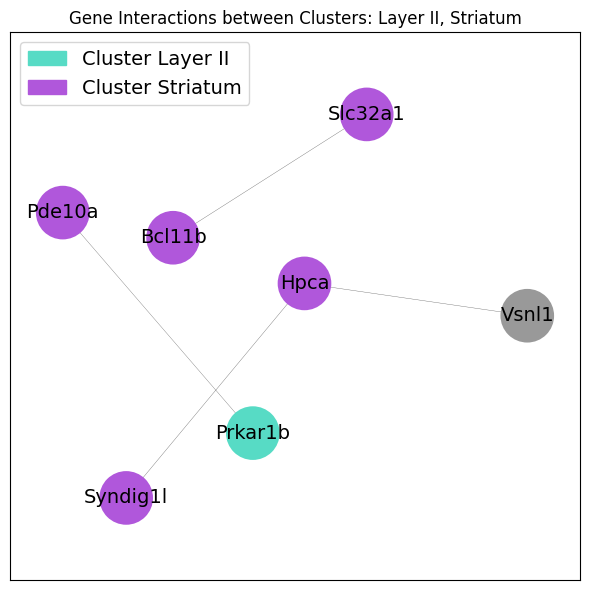

In [67]:
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Wedge, Circle
custom_cluster_colors = ["#003F5C","#A3BD5C","#2879CD","#64CCC5", "#8965B3","#A84622",
 "#AB599D",  "#898121",  "#E56674","#FF90BB","#EB7B27", "#F2BE22",  "#196687", "#AAC8A7", "#B31312",
 "#7A3E3E", "#FFC95F","#6527BE", "#FAE392", "#519872",  "#DD58D6","#19EF19","#4A31EC","#F3FA14","#718481",
 "#7CA2C3","#680A98","#CC2888","#F5062C","#C55E6F","#2B7012","#083C9D","#4B3853","#A98907","#AAA7F6","#CBE732","#D8DFB0","red","green"]
    # 如果有其他集群，也可以在这里定义，否则会自动分配  
 
# ['#A3BD5C', '#AAC8A7']
# ['#FF90BB', '#F2BE22']

plot_cluster_network_with_multi_cluster(result, selected_clusters=["Striatum","Layer II"],cluster_colors=None, node_radius=0.1, weight_scale=20, gene_to_clusters=gene_to_clusters)
